# Perceptron Classifier 

This notebook demonstrates the **Perceptron algorithm** implemented entirely
from scratch using the `rice_ml` package.

We will:
- Load and explore a real dataset
- Perform exploratory data analysis (EDA)
- Preprocess features and labels
- Train a Perceptron classifier
- Visualize decision boundaries using PCA
- Evaluate classification performance


## Motivation 

The Perceptron is one of the earliest learning algorithms in machine learning,
introduced by Frank Rosenblatt in 1958. Despite its simplicity, it laid the
foundation for modern neural networks and large-scale optimization methods.

### Why study the Perceptron today?

- It is the **simplest trainable linear classifier**
- It demonstrates **online learning and mistake-driven updates**
- It highlights the importance of **linear separability**
- It provides intuition for gradient-based learning algorithms

Understanding the Perceptron helps explain why more advanced models such as
logistic regression, support vector machines, and neural networks behave the
way they do.



## Problem Setting and Notation

We consider a **binary classification problem** with:

- Feature matrix  
  X ∈ ℝⁿˣᵈ  
  where n is the number of samples and d is the number of features

- Target vector  
  y ∈ {0, 1}ⁿ  

The goal is to learn a linear decision function:

f(x) = w · x + b

such that:
- f(x) ≥ 0 → predict class 1
- f(x) < 0 → predict class 0

The vector w defines the orientation of the decision boundary, while the bias
term b shifts the boundary away from the origin.


## The Perceptron Learning Rule

The Perceptron learns using a **mistake-driven update rule**.

For each training example (xᵢ, yᵢ):

1. Compute the prediction:
   ŷᵢ = sign(w · xᵢ + b)

2. If the prediction is correct, do nothing

3. If the prediction is incorrect, update:

   w ← w + η · (yᵢ - ŷᵢ) · xᵢ  
   b ← b + η · (yᵢ - ŷᵢ)

where η > 0 is the learning rate.

Key properties:
- Updates occur **only on misclassified samples**
- No explicit loss function is minimized
- The algorithm is guaranteed to converge *if and only if*
  the data are linearly separable


## Dataset Description: Ionosphere

We use the **Ionosphere dataset** from the UCI Machine Learning Repository.

This dataset consists of radar signal returns used to determine whether an
object in the ionosphere is classified as "good" or "bad".

Dataset characteristics:
- Number of samples: 351
- Number of features: 34
- Feature type: continuous numerical values
- Target variable:
  - 1 → good radar return
  - 0 → bad radar return
- No missing values

This dataset is well-suited for studying linear classifiers, as many of the
features are correlated and continuous, but the classes are not perfectly
separable.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice_ml.supervised_learning.perceptron import Perceptron
from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.processing.post_processing import accuracy_score

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
df = pd.read_csv(url, header=None)

# Features and labels
X = df.iloc[:, :-1].values.astype(float)
y = (df.iloc[:, -1] == "g").astype(int)

print("Shape of X:", X.shape)
print("Class distribution:", np.bincount(y))

Shape of X: (351, 34)
Class distribution: [126 225]


## Exploratory Data Analysis (EDA)

Before modeling, we examine:
- Target class balance
- Feature scale differences

This helps determine appropriate preprocessing steps.


### Target Distribution

We first examine how many samples belong to each class.

A heavily imbalanced dataset can bias a linear classifier toward the majority
class, especially when updates are mistake-driven.

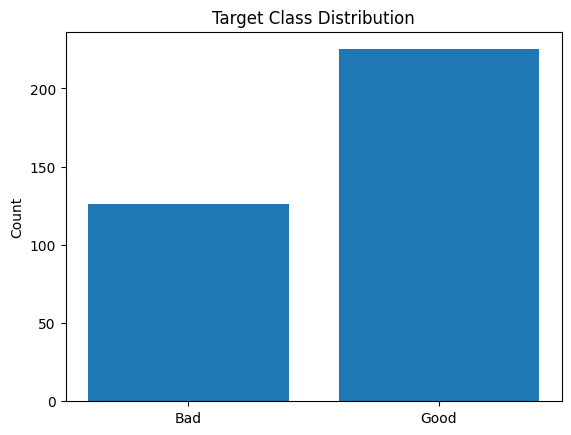

In [16]:
plt.bar(["Bad", "Good"], np.bincount(y))
plt.title("Target Class Distribution")
plt.ylabel("Count")
plt.show()

The Ionosphere dataset is moderately balanced, which reduces the risk of
systematic bias in the learned decision boundary.

### Feature Scale Analysis

The Perceptron updates weights proportionally to feature values.

If features have vastly different scales:
- Large-scale features dominate updates
- Small-scale features become effectively irrelevant
- Training becomes unstable or slow

To diagnose this, we visualize feature ranges before preprocessing.


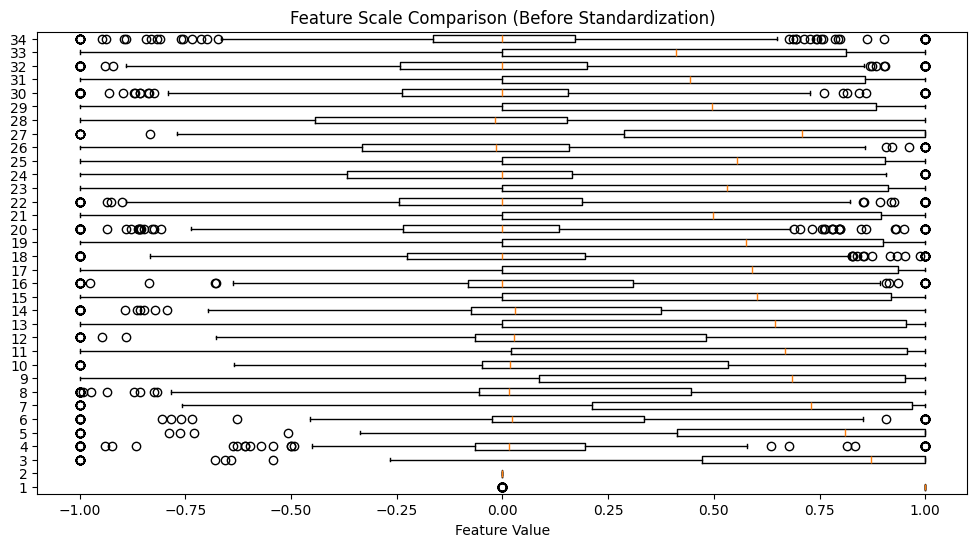

In [17]:
plt.figure(figsize=(12, 6))
plt.boxplot(X, vert=False)
plt.title("Feature Scale Comparison (Before Standardization)")
plt.xlabel("Feature Value")
plt.show()

The features exhibit **large differences in scale**, which can negatively
impact gradient-based updates. This motivates standardization.


## Preprocessing

We apply **standardization**:

X_std = (X − μ) / σ

This ensures:
- All features contribute equally
- Faster and more stable convergence
- Better numerical behavior

We then split the data into training and testing sets using an 80/20 split.


In [18]:
X_std = standardize(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((281, 34), (70, 34))

## Model Training

We now train the Perceptron using our custom implementation from `rice_ml`.

Key hyperparameters:
- learning_rate: controls update magnitude
- max_iter: maximum number of training passes over the data
- random_state: ensures reproducibility

The model iteratively refines a linear decision boundary based on
misclassifications in the training set.



In [19]:
model = Perceptron(
    learning_rate=0.1,
    max_iter=1000,
    random_state=42
)

model.fit(X_train, y_train)

## Evaluation Metric

We evaluate model performance using **classification accuracy**:

Accuracy = (1 / n) Σ 𝟙[yᵢ = ŷᵢ]

Accuracy measures the fraction of correctly classified samples.
While simple, it is appropriate here due to the relatively balanced classes.


In [20]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Perceptron Test Accuracy: {acc:.3f}")


Perceptron Test Accuracy: 0.829


### Interpretation of Performance

The Perceptron achieves reasonable accuracy but does not perfectly classify the data.
This behavior is expected because the Ionosphere dataset is not linearly separable.
Even after standardization, significant class overlap remains, which limits the
performance of any linear classifier.

This result highlights a core theoretical property of the Perceptron: it is
guaranteed to converge only when the data are linearly separable.


## Visualizing the Decision Boundary with PCA

The Ionosphere dataset has 34 features, which cannot be visualized directly.

We apply **Principal Component Analysis (PCA)** to project the data onto two dimensions while preserving maximum variance.

Important note:
- PCA is used **only for visualization**
- The Perceptron is trained in the full feature space


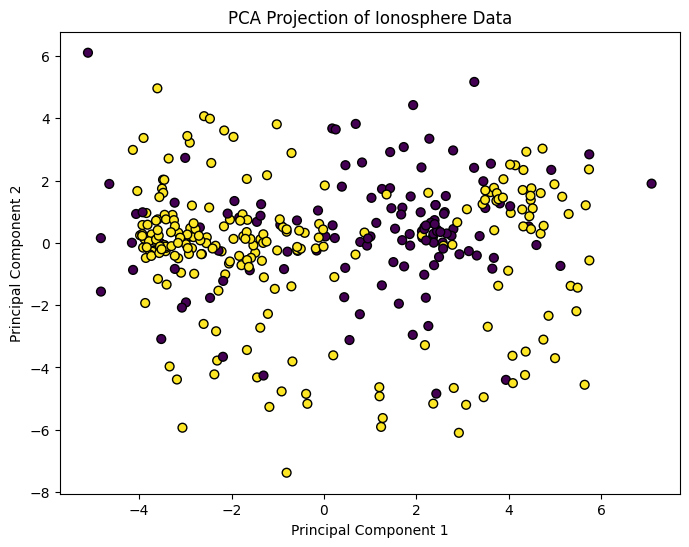

In [21]:
from rice_ml.unsupervised_learning.pca import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_std)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y,
    cmap="viridis",
    edgecolor="k",
    s=40
)
plt.title("PCA Projection of Ionosphere Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


The PCA projection reveals significant overlap between the two classes.
Because the Perceptron learns a single linear decision boundary, it cannot
separate overlapping regions in feature space. This explains why performance
plateaus even with careful preprocessing.


## Perceptron vs Logistic Regression

Both the Perceptron and Logistic Regression are linear classifiers.
However, logistic regression optimizes a smooth loss function and produces
probabilistic outputs, while the Perceptron relies on mistake-driven updates
and produces hard classifications.

As a result, logistic regression is generally more stable on noisy datasets,
while the Perceptron provides a simpler and more intuitive learning rule.


## Limitations of the Perceptron

While simple and interpretable, the Perceptron has important limitations:

- Can only learn linear decision boundaries
- Fails on non-linearly separable data
- No probabilistic output
- Sensitive to noisy labels

These limitations motivate more advanced models such as:
- Logistic Regression
- Support Vector Machines
- Neural Networks



## Conclusion

In this notebook, we demonstrated the Perceptron algorithm using a
fully custom implementation from the `rice_ml` package.

Key takeaways:
- The Perceptron learns a linear decision boundary
- Feature scaling is essential for stable training
- PCA helps visualize high-dimensional data
- The algorithm is simple, efficient, and interpretable

This notebook serves as a foundational supervised learning example
within the `rice_ml` framework.
